In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Liberaries

In [2]:
!source /content/drive/MyDrive/colab_env/bin/activate

In [3]:
import os
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import netCDF4 as gpd
import ee
import wxee
import geemap
import rioxarray
import rasterio
import pickle
import geopandas as gpd

sys.path.append('/content/drive/MyDrive/WaterBalance_new/')

from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *
from qdwb.coordinate.extract import *

In [4]:
ee.Authenticate()
wxee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=iG5MmFNQavoODKRArKbZCxv5630M0KI-bFdhwnPVfVc&tc=jmVZlbdd_qMlTBvI-FfvaGE1MEZyx1u1_sOoGEcwyhE&cc=0Arsq-JNabCK3rh9M5R99vKoozLPoZAUNg9zgzhGkSo

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VMDPAOh3f-zxaaGbXMDGpzNRcNXpY_cclKF49DzIh5J_IqPxNu__X4

Successfully saved authorization token.


# Varables

In [5]:
PATH_DATA = "/content/drive/MyDrive/WaterBalance_new/assets/"

# mashhad
LAT_MIN = 35.80
LAT_MAX = 37.11
LON_MIN = 58.31
LON_MAX = 60.14

# USA
# LAT_MIN = 43.30
# LAT_MAX = 44.60
# LON_MIN = -109.40
# LON_MAX = -107.40


# Functions

In [6]:
def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result

# Load Data

In [7]:
# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "nc/P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
 
# mashhad = gpd.read_file('/mnt/e/Term2/WERI/test/Export_Output.shp')

usa = gpd.read_file(PATH_DATA + "shape/usa.shp")
mashhad = gpd.read_file(PATH_DATA + "shape/mahdoode_mashhad.shp")


In [8]:


# Map = geemap.Map()
# Map.add_basemap('HYBRID')


shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])


# Import the GCN250 Images and rename bands
# GCN250_Average =  ee.Image("users/jaafarhadi/GCN250/GCN250Average").select('b1').rename('average')
CN_Wyoming =  ee.Image("users/jaafarhadi/GCN250/GCN250Dry").select('b1').rename('dry')
# GCN250_Wet = ee.Image("users/jaafarhadi/GCN250/GCN250Wet").select('b1').rename('wet')


CN_Wyoming = CN_Wyoming.clip(shape)
 
# Map.centerObject(shape, 9)
# Map.addLayer(CN_Wyoming, {'min':40, 'max':75, 'palette': ['Red','SandyBrown','Yellow','LimeGreen', 'Blue','DarkBlue']}, 'CN_Wyoming')
# Map

In [9]:
CN_Wyoming = CN_Wyoming.set("system:time_start", ee.Date("2015"))
arr = CN_Wyoming.wx.to_xarray(scale=250, crs='EPSG:4326')
arr

Downloading:   0%|          | 0.00/71.0k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:  (time: 1, y: 586, x: 816)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 37.11 37.11 37.11 37.11 37.1 ... 35.81 35.8 35.8 35.8
  * x        (x) float64 58.31 58.31 58.32 58.32 ... 60.13 60.14 60.14 60.14
Data variables:
    dry      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:               (0.002245788210298804, 0.0, 58.309645092198146, ...
    crs:                     +init=epsg:4326
    res:                     (0.002245788210298804, 0.002245788210298804)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## reroject CN array accoring to precipitation array

In [10]:

da = arr.rio.write_crs("epsg:4326", inplace=True)

P.rio.write_crs("epsg:4326", inplace=True)

p = P.rename({'lon': 'x','lat': 'y'})

xds_repr_match = da.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match


<xarray.Dataset>
Dimensions:      (x: 18, y: 13, time: 1)
Coordinates:
  * x            (x) float32 58.35 58.45 58.55 58.65 ... 59.75 59.85 59.95 60.05
  * y            (y) float32 37.05 36.95 36.85 36.75 ... 36.15 36.05 35.95 35.85
  * time         (time) datetime64[ns] 2015-01-01
    spatial_ref  int64 0
Data variables:
    dry          (time, y, x) float64 75.0 57.0 57.0 57.0 ... 57.0 59.0 75.0
Attributes:
    transform:               (0.002245788210298804, 0.0, 58.309645092198146, ...
    res:                     (0.002245788210298804, 0.002245788210298804)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## plot reprojected CN array

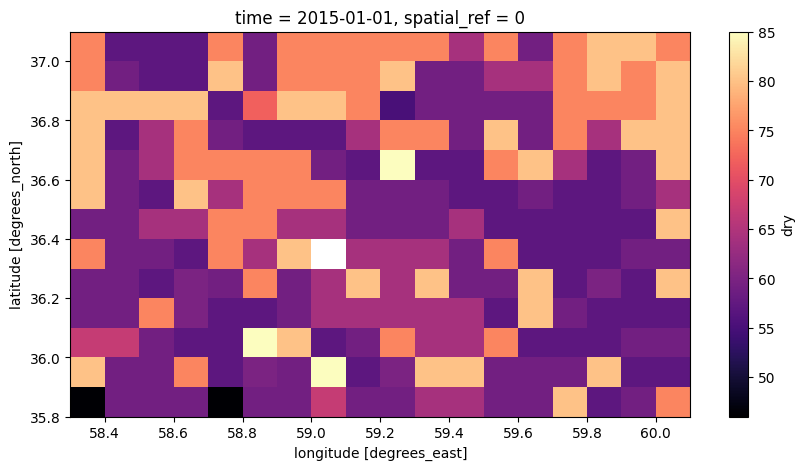

In [11]:
xds_repr_match.dry.plot(figsize=(10, 5), cmap="magma")

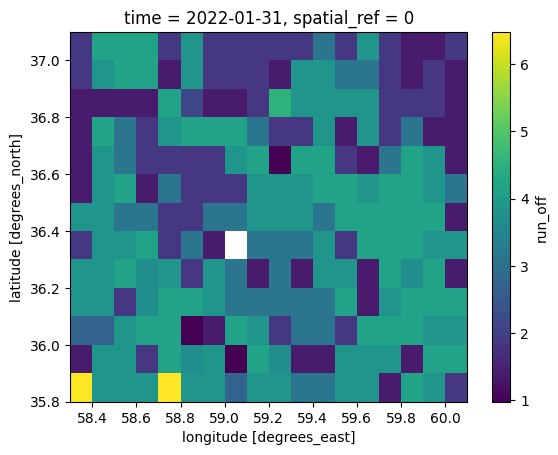

In [12]:
cn =list(xds_repr_match.dry.values.flatten())
pre =list(p.precipitation.values.flatten())

run_off = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[0]
for i, j in zip(pre,cn)])

underground_runoff = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[1]
for i, j in zip(pre,cn)])

run_off_array = run_off.reshape(1,13,18)
underground_runoff_array = underground_runoff.reshape(1,13,18)


ds_array = p.assign(run_off=(['time', 'y', 'x'], run_off_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds_array_1.run_off.plot()


In [13]:
# Map = geemap.Map()
# Map.add_basemap('HYBRID')

soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('ssm').mean().clip(shape)

sub_soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('susm').mean().clip(shape)
# Map.centerObject(shape, 9)
# Map.addLayer(soilmoisture, {'min':0, 'max':28, 'palette': ['0300ff', '418504', 'efff07', 'efff07', 'ff0303']}, 'soilmoisture')
# Map

In [14]:
soil_era_evap = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-01-31', '2022-02-01')).select('volumetric_soil_water_layer_1').mean().clip(shape)

In [18]:
soilmoisture = soilmoisture.set("system:time_start", ee.Date("2022-01-31"))
sub_soilmoisture = sub_soilmoisture.set("system:time_start", ee.Date("2022-01-31"))
soil_era_evap_1 = soil_era_evap.set("system:time_start", ee.Date("2022-01-31"))

arr_soilmoisture = soilmoisture.wx.to_xarray(scale=10000, crs='EPSG:4326')
arr_sub_soilmoisture = sub_soilmoisture.wx.to_xarray(scale=10000, crs='EPSG:4326')
arr_soil_era_evap_1 = soil_era_evap_1.wx.to_xarray(scale=11132, crs='EPSG:4326')
arr_soil_era_evap_1

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:                        (time: 1, y: 15, x: 19)
Coordinates:
  * time                           (time) datetime64[ns] 2022-01-31
  * y                              (y) float64 37.15 37.05 36.95 ... 35.85 35.75
  * x                              (x) float64 58.35 58.45 58.55 ... 60.05 60.15
Data variables:
    volumetric_soil_water_layer_1  (time, y, x) float64 0.3014 0.3099 ... nan
Attributes:
    transform:               (0.10000045742818513, 0.0, 58.30026668063193, 0....
    crs:                     +init=epsg:4326
    res:                     (0.10000045742818513, 0.10000045742818513)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [19]:
da_soilmoisture = arr_soilmoisture.rio.write_crs("epsg:4326", inplace=True)
da_sub_soilmoisture = arr_sub_soilmoisture.rio.write_crs("epsg:4326", inplace=True)
da_soil_era_evap_1 = arr_soil_era_evap_1.rio.write_crs("epsg:4326", inplace=True)


xds_repr_match__soilmoisture = da_soilmoisture.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__sub_soilmoisture = da_sub_soilmoisture.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__soil_era_evap_1 = da_soil_era_evap_1.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)


xds_repr_match__soil_era_evap_1 = xds_repr_match__soil_era_evap_1 * 70
xds_repr_match__soil_era_evap_1

<xarray.Dataset>
Dimensions:                        (x: 18, y: 13, time: 1)
Coordinates:
  * x                              (x) float32 58.35 58.45 58.55 ... 59.95 60.05
  * y                              (y) float32 37.05 36.95 36.85 ... 35.95 35.85
  * time                           (time) datetime64[ns] 2022-01-31
    spatial_ref                    int64 0
Data variables:
    volumetric_soil_water_layer_1  (time, y, x) float64 21.95 22.47 ... 8.413
Attributes:
    transform:               (0.10000045742818513, 0.0, 58.30026668063193, 0....
    res:                     (0.10000045742818513, 0.10000045742818513)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

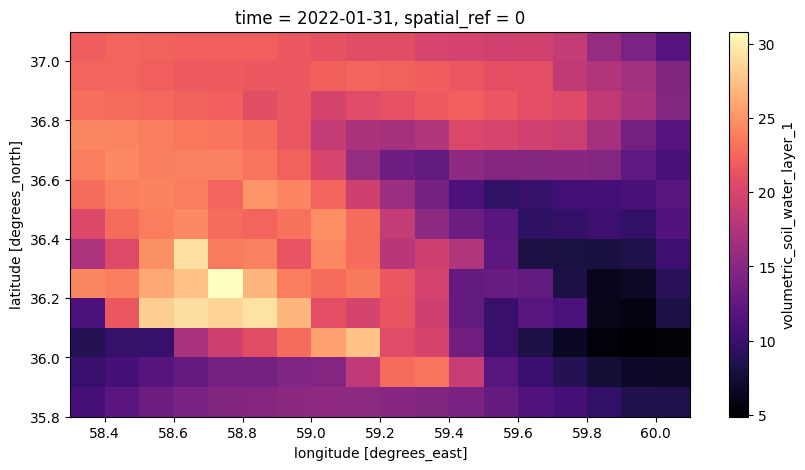

In [20]:
xds_repr_match__soil_era_evap_1.volumetric_soil_water_layer_1.plot(figsize=(10, 5), cmap="magma")

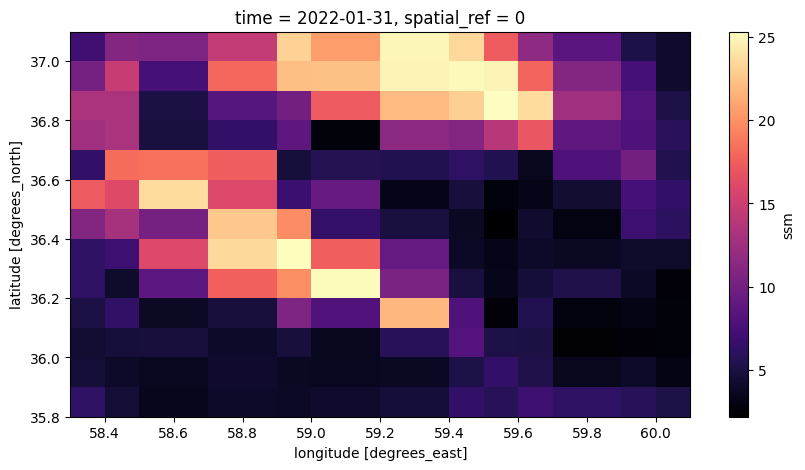

In [23]:
xds_repr_match__soilmoisture.ssm.plot(figsize=(10, 5), cmap="magma")

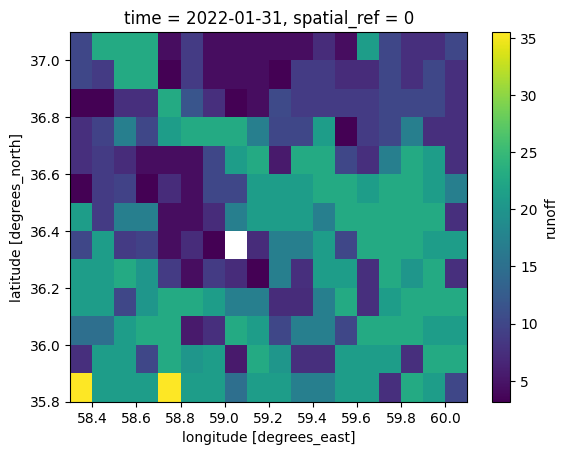

In [45]:
cn = list(xds_repr_match.dry.values.flatten())
pre = list(p.precipitation.values.flatten())
soil = list(xds_repr_match__soilmoisture.ssm.values.flatten())
sub_soil = list(xds_repr_match__sub_soilmoisture.susm.values.flatten())
soil_era = list(xds_repr_match__soil_era_evap_1.volumetric_soil_water_layer_1.values.flatten())

runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[0]
for i, j, z in zip(pre, cn, soil)])

underground_runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[1]
for i, j, z in zip(pre, cn, soil)])

soil_array = np.array(soil)
sub_soil_array = np.array(sub_soil)
soil_era_array = np.array(soil_era)

runoff_array = runoff_array.reshape(1,13,18)
underground_runoff_array = underground_runoff_array.reshape(1,13,18)
soil_array = soil_array.reshape(1,13,18)
sub_soil_array = sub_soil_array.reshape(1,13,18)
soil_era_array = soil_era_array.reshape(1,13,18)


ds_array = p.assign(runoff=(['time', 'y', 'x'], runoff_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds_array_2 = ds_array_1.assign(soilmoisture=(['time', 'y', 'x'], soil_array))
ds_array_3 = ds_array_2.assign(sub_soilmoisture=(['time', 'y', 'x'], sub_soil_array))
ds_array_3_1 = ds_array_3.assign(soil_era=(['time', 'y', 'x'], soil_era_array))


ds_array_3_1.runoff.plot()



In [46]:
df = ds_array_3_1.to_dataframe()

with pd.ExcelWriter('/content/drive/MyDrive/WaterBalance_new/assets/output_nasa.xlsx') as writer:
    df.to_excel(writer)

In [48]:
df_1 = xds_repr_match.to_dataframe()
with pd.ExcelWriter('/content/drive/MyDrive/WaterBalance_new/assets/cn.xlsx') as writer:
    df_1.to_excel(writer)

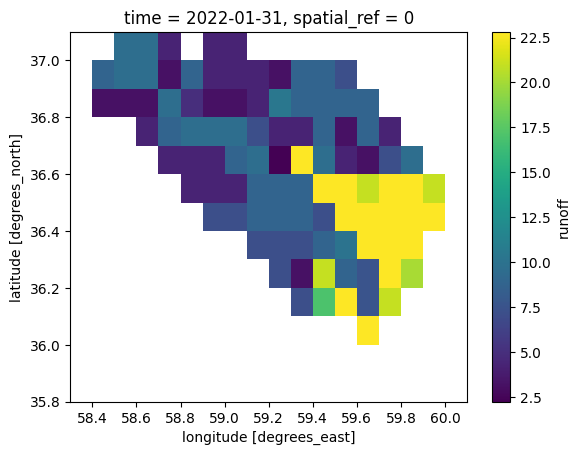

In [41]:


# shp_dir = PATH_DATA + "shape/usa.shp"
shp_dir = PATH_DATA + "shape/mahdoode_mashhad.shp"

shapefile = gpd.read_file(shp_dir)


precip_da = add_shape_coord_from_data_array(ds_array_3_1, shp_dir, "shapefile")
ds_array_4 = ds_array_3_1.where(precip_da.shapefile==0, other=np.nan)



# with open('/content/drive/MyDrive/WaterBalance/notebook/ds_array_4_mahdoode_mashhad.pkl', 'wb') as f:
#     pickle.dump(ds_array_4, f)

ds_array_4.runoff.plot()


In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

dem = ee.Image("USGS/SRTMGL1_003").clip(shape)

Map.centerObject(shape, 9)
Map.addLayer(ee_object = dem, vis_params = {'min':-10, 'max':6500}, name = 'dem')
Map

Map(center=[43.95199004841242, -108.40000000000003], controls=(WidgetControl(options=['position', 'transparent…